## Image Augmentation

`alexnet`一节中提到过大型数据集是成功应用深度神经网络的先决条件。
图像增广在对训练图像进行一系列的随机变化之后，生成相似但不同的训练样本，从而扩大了训练集的规模。
此外，应用图像增广的原因是，随机改变训练样本可以减少模型对某些属性的依赖，从而提高模型的泛化能力。
例如，我们可以以不同的方式裁剪图像，使感兴趣的对象出现在不同的位置，减少模型对于对象出现位置的依赖。
我们还可以调整亮度、颜色等因素来降低模型对颜色的敏感度。
可以说，图像增广技术对于AlexNet的成功是必不可少的。

In [1]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

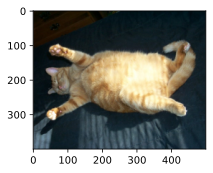

In [2]:
d2l.set_figsize()
img = d2l.Image.open('./img/cat1.jpg')
d2l.plt.imshow(img);

大多数图像增广方法都具有一定的随机性。为了便于观察图像增广的效果，我们下面定义辅助函数`apply`。
此函数在输入图像`img`上多次运行图像增广方法`aug`并显示所有结果。

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### Flip & Cut

**左右翻转图像**通常不会改变对象的类别。这是最早且最广泛使用的图像增广方法之一。
接下来，我们使用`transforms`模块来创建`RandomFlipLeftRight`实例，这样就各有50%的几率使图像向左或向右翻转。

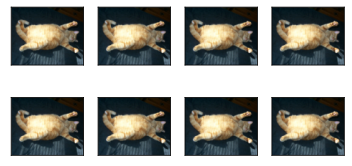

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

**上下翻转图像**不如左右图像翻转那样常用。但是，至少对于这个示例图像，上下翻转不会妨碍识别。

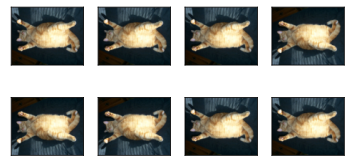

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

在`pooling`一节中，我们解释了汇聚层可以降低卷积层对目标位置的敏感性。
另外，我们可以通过对图像进行随机裁剪，使物体以不同的比例出现在图像的不同位置。
这也可以降低模型对目标位置的敏感性。

下面的代码将**随机裁剪**一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值。
然后，区域的宽度和高度都被缩放到200像素。
在本节中（除非另有说明），$a$和$b$之间的随机数指的是在区间$[a, b]$中通过均匀采样获得的连续值。

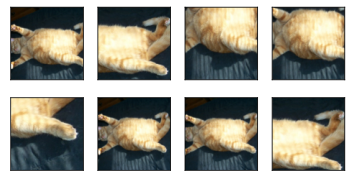

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### Change the Color

另一种增广方法是改变颜色。
我们可以改变图像颜色的四个方面：亮度、对比度、饱和度和色调。
在下面的示例中，我们**随机更改图像的亮度**，随机值为原始图像的50%（$1-0.5$）到150%（$1+0.5$）之间。

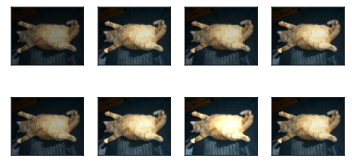

In [7]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

同样，我们可以**随机更改图像的色调**。

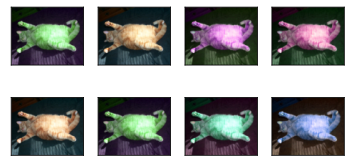

In [8]:
apply(img, torchvision.transforms.ColorJitter(hue=0.5, brightness=0, contrast=0, saturation=0))

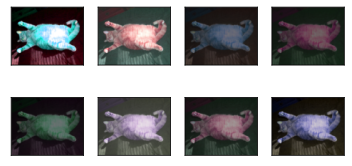

In [9]:
color_aug = torchvision.transforms.ColorJitter(hue=0.5, brightness=0.5, contrast=0.5, saturation=0.5)
apply(img, color_aug)

### Compose

在实践中，我们将结合多种图像增广方法。比如，我们可以通过使用一个`Compose`实例来综合上面定义的不同的图像增广方法，并将它们应用到每个图像。

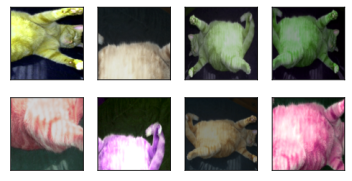

In [10]:
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

## Train With Picture Augment

Files already downloaded and verified


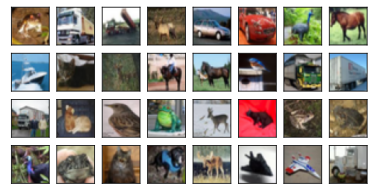

In [11]:
all_images = torchvision.datasets.CIFAR10(train=True, root='./data', download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，且在预测过程中不使用随机操作的图像增广。
在这里，我们**只使用最简单的随机左右翻转**。
此外，我们使用`ToTensor`实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0～1。

In [18]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

接下来，我们**定义一个辅助函数，以便于读取图像和应用图像增广**。PyTorch数据集提供的`transform`参数应用图像增广来转化图像。

In [13]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root='./data', train=is_train, transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              shuffle=is_train, num_workers = d2l.get_dataloader_workers())
    return dataloader

In [14]:
# Train
def train_batch_ch13(net, X, y , loss, trainer, devices):
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    ###################
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    ###################
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [15]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, 
                             (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc {metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')

现在，我们可以**定义`train_with_data_aug`函数，使用图像增广来训练模型**。该函数获取所有的GPU，并使用Adam作为训练的优化算法，将图像增广应用于训练集，最后调用刚刚定义的用于训练和评估模型的`train_ch13`函数。

In [17]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.170, train acc 0.941, test acc 0.841
1482.7 examples/sec on [device(type='cuda', index=0)]


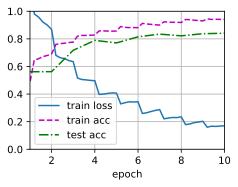

In [20]:
train_with_data_aug(train_augs, test_augs, net)

### Without Augment

loss 0.032, train acc 0.989, test acc 0.846
1499.8 examples/sec on [device(type='cuda', index=0)]


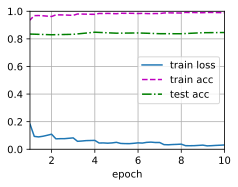

In [23]:
def train_without_data_aug(no_augs):
    train_iter = load_cifar10(True, no_augs, batch_size)
    test_iter = load_cifar10(False, no_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=0.001)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

no_augs = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_without_data_aug(no_augs)

### More Augment

In [ ]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=(-10, 10)),   # 随机旋转，-10到10度之间随机选
    torchvision.transforms.RandomHorizontalFlip(p=0.5),         # 随机水平翻转 选择一个概率概率
    torchvision.transforms.RandomVerticalFlip(p=0.5),           # 随机垂直翻转
    torchvision.transforms.ToTensor(),          # 将PIL Image或numpy.ndarray转换为tensor，并归一化到[0,1]之间
])
train_with_data_aug(augs, test_augs, net)

## Fine Tuning

本节将介绍迁移学习中的常见技巧:*微调*（fine-tuning）。如下图所示，微调包括以下四个步骤。

1. 在源数据集（例如ImageNet数据集）上预训练神经网络模型，即*源模型*。
1. 创建一个新的神经网络模型，即*目标模型*。这将复制源模型上的所有模型设计及其参数（输出层除外）。我们假定这些模型参数包含从源数据集中学到的知识，这些知识也将适用于目标数据集。我们还假设源模型的输出层与源数据集的标签密切相关；因此不在目标模型中使用该层。
1. 向目标模型添加输出层，其输出数是目标数据集中的类别数。然后随机初始化该层的模型参数。
1. 在目标数据集（如椅子数据集）上训练目标模型。输出层将从头开始进行训练，而所有其他层的参数将根据源模型的参数进行微调。

![微调。](./img/finetune.svg)

当目标数据集比源数据集小得多时，微调有助于提高模型的泛化能力。

让我们通过具体案例演示微调：热狗识别。
我们将在一个小型数据集上微调ResNet模型。该模型已在ImageNet数据集上进行了预训练。
这个小型数据集包含数千张包含热狗和不包含热狗的图像，我们将使用微调模型来识别图像中是否包含热狗。

In [1]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

### Access the Datasets

我们使用的**热狗数据集来源于网络**。
该数据集包含1400张热狗的“正类”图像，以及包含尽可能多的其他食物的“负类”图像。
含着两个类别的1000张图片用于训练，其余的则用于测试。

解压下载的数据集，我们获得了两个文件夹`hotdog/train`和`hotdog/test`。
这两个文件夹都有`hotdog`（有热狗）和`not-hotdog`（无热狗）两个子文件夹，
子文件夹内都包含相应类的图像。

In [2]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 
                          'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

In [3]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

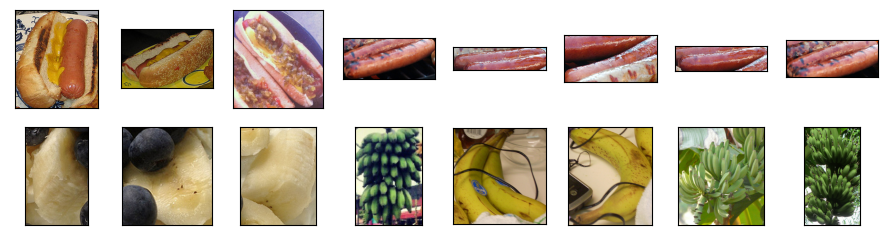

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs=[train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

在训练期间，我们首先从图像中裁切随机大小和随机长宽比的区域，然后将该区域缩放为$224 \times 224$输入图像。
在测试过程中，我们将图像的高度和宽度都缩放到256像素，然后裁剪中央$224 \times 224$区域作为输入。
此外，对于RGB（红、绿和蓝）颜色通道，我们分别*标准化*每个通道。
具体而言，该通道的每个值减去该通道的平均值，然后将结果除以该通道的标准差。

In [5]:
# 使用RGB通道的均值和标准差，以标准化每个通道
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize
])

### Init Model

我们使用在ImageNet数据集上预训练的ResNet-18作为源模型。
在这里，我们指定`pretrained=True`以自动下载预训练的模型参数。

In [6]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

c:\Users\Jason Chen\.conda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jason Chen\.conda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


预训练的源模型实例包含许多特征层和一个输出层`fc`。
此划分的主要目的是促进对除输出层以外所有层的模型参数进行微调。
下面给出了源模型的成员变量`fc`。

In [7]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

在ResNet的全局平均汇聚层后，全连接层转换为ImageNet数据集的1000个类输出。
之后，我们构建一个新的神经网络作为目标模型。
它的定义方式与预训练源模型的定义方式相同，只是最终层中的输出数量被设置为目标数据集中的类数（而不是1000个）。

在下面的代码中，目标模型`finetune_net`中成员变量`features`的参数被初始化为源模型相应层的模型参数。
由于模型参数是在ImageNet数据集上预训练的，并且足够好，因此通常只需要较小的学习率即可微调这些参数。

成员变量`output`的参数是随机初始化的，通常需要更高的学习率才能从头开始训练。
假设`Trainer`实例中的学习率为$\eta$，我们将成员变量`output`中参数的学习率设置为$10\eta$。


In [8]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

### Fine Tuning

In [9]:
# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
                os.path.join(data_dir, 'train'), transform=train_augs),
                batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
                os.path.join(data_dir, 'test'), transform=test_augs),
                batch_size=batch_size)
    
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction='none')

    if param_group:
        param_1x = [param for name, param in net.named_parameters()
                    if name not in ['fc.weight', 'fc.bias']]
        trainer = torch.optim.SGD([{'params': param_1x}, {'params': net.fc.parameters(), 'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

我们**使用较小的学习率**，通过**微调**预训练获得的模型参数。

loss 0.190, train acc 0.934, test acc 0.940
370.3 examples/sec on [device(type='cuda', index=0)]


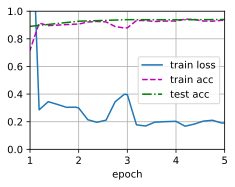

In [10]:
train_fine_tuning(finetune_net, 5e-5)

为了进行比较，我们定义了一个相同的模型，但是将其**所有模型参数初始化为随机值**。
由于整个模型需要从头开始训练，因此我们需要使用更大的学习率。


loss 0.340, train acc 0.851, test acc 0.840
411.7 examples/sec on [device(type='cuda', index=0)]


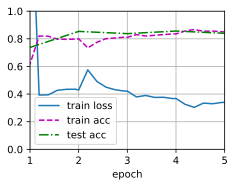

In [11]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

意料之中，微调模型往往表现更好，因为它的初始参数值更有效。

loss 0.123, train acc 0.959, test acc 0.938
364.1 examples/sec on [device(type='cuda', index=0)]


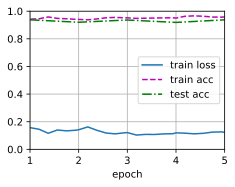

In [12]:
train_fine_tuning(finetune_net, 5e-5, param_group=False)

loss 0.184, train acc 0.929, test acc 0.899
432.3 examples/sec on [device(type='cuda', index=0)]


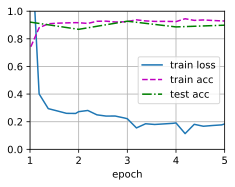

In [13]:
#获取预训练模型“热狗”类别输出层的参数
pretrained_net = torchvision.models.resnet18(pretrained=True)
weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]

finetune_net = torchvision.models.resnet18(pretrained=True)

finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)
finetune_net.fc.weight.data[0]= hotdog_w.data.reshape(-1)#关键代码

train_fine_tuning(finetune_net, 5e-5)

## Bounding Box

前面的章节（例如`alexnet`—`googlenet`）介绍了各种图像分类模型。
在图像分类任务中，我们假设图像中只有一个主要物体对象，我们只关注如何识别其类别。
然而，很多时候图像里有多个我们感兴趣的目标，我们不仅想知道它们的类别，还想得到它们在图像中的具体位置。
在计算机视觉里，我们将这类任务称为*目标检测*（object detection）或*目标识别*（object recognition）。

接下来的几节将介绍几种用于目标检测的深度学习方法。
我们将首先介绍目标的*位置*。

In [1]:
import torch
from d2l import torch as d2l

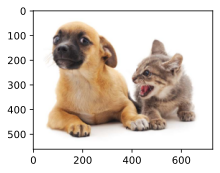

In [2]:
d2l.set_figsize()
img = d2l.plt.imread('./img/catdog.jpg')
d2l.plt.imshow(img)

### BBox

边界框是矩形的，由矩形左上角的以及右下角的$x$和$y$坐标决定。
另一种常用的边界框表示方法是边界框中心的$(x, y)$轴坐标以及框的宽度和高度。

在这里，我们**定义在这两种表示法之间进行转换的函数**：`box_corner_to_center`从两角表示法转换为中心宽度表示法，而`box_center_to_corner`反之亦然。
输入参数`boxes`可以是长度为4的张量，也可以是形状为（$n$，4）的二维张量，其中$n$是边界框的数量。

In [3]:
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [4]:
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

我们可以通过转换两次来验证边界框转换函数的正确性。

In [5]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [6]:
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0], height=bbox[3] - bbox[1],
        fill=False, edgecolor=color, linewidth=2)

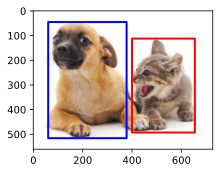

In [7]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

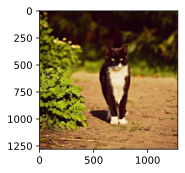

In [9]:
d2l.set_figsize()
img = d2l.plt.imread('./img/cat2.jpg')
d2l.plt.imshow(img)
cat_bbox= [552.0, 335.0, 848.0, 1076.0]
boxes = torch.tensor([cat_bbox])#增加一个维度，批量大小为1

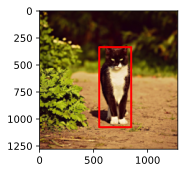

In [10]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(d2l.bbox_to_rect(cat_bbox, 'red'))

## Anchor

目标检测算法通常会在输入图像中采样大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边界从而更准确地预测目标的*真实边界框*（ground-truth bounding box）。
不同的模型使用的区域采样方法可能不同。
这里我们介绍其中的一种方法：以每个像素为中心，生成多个缩放比和宽高比（aspect ratio）不同的边界框。
这些边界框被称为*锚框*（anchor box）我们将在`ssd`中设计一个基于锚框的目标检测模型。

首先，让我们修改输出精度，以获得更简洁的输出。

In [1]:
import torch
from d2l import torch as d2l

torch.set_printoptions(2)

假设输入图像的高度为$h$，宽度为$w$。
我们以图像的每个像素为中心生成不同形状的锚框：*缩放比*为$s\in (0, 1]$，*宽高比*为$r > 0$。
那么**锚框的宽度和高度分别是$hs\sqrt{r}$和$hs/\sqrt{r}$。**
请注意，当中心位置给定时，已知宽和高的锚框是确定的。

要生成多个不同形状的锚框，让我们设置许多缩放比（scale）取值$s_1,\ldots, s_n$和许多宽高比（aspect ratio）取值$r_1,\ldots, r_m$。
当使用这些比例和长宽比的所有组合以每个像素为中心时，输入图像将总共有$whnm$个锚框。
尽管这些锚框可能会覆盖所有真实边界框，但计算复杂性很容易过高。
在实践中，**我们只考虑**包含$s_1$或$r_1$的**组合：**

$$
(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).
$$

也就是说，以同一像素为中心的锚框的数量是$n+m-1$。
对于整个输入图像，将共生成$wh(n+m-1)$个锚框。

上述生成锚框的方法在下面的`multibox_prior`函数中实现。
我们指定输入图像、尺寸列表和宽高比列表，然后此函数将返回所有的锚框。

In [2]:
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height
    steps_w = 1.0 / in_width

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # 生成“boxes_per_pixel”个高和宽，
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width  # 处理矩形输入
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]), 
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # 除以2来获得半高和半宽
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
        in_height * in_width, 1) / 2  #（批量大小，锚框的数量，4）
    
    # 每个中心点都将有“boxes_per_pixel”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
    out_grid =torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(
        boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

可以看到**返回的锚框变量`Y`的形状**是（批量大小，锚框的数量，4）。


In [3]:
img = d2l.plt.imread('./img/catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

将锚框变量`Y`的形状更改为(图像高度,图像宽度,以同一像素为中心的锚框的数量,4)后，我们可以获得以指定像素的位置为中心的所有锚框。
在接下来的内容中，我们**访问以（250,250）为中心的第一个锚框**。
它有四个元素：锚框左上角的$(x, y)$轴坐标和右下角的$(x, y)$轴坐标。
输出中两个轴的坐标各分别除以了图像的宽度和高度。

In [4]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.06, 0.07, 0.63, 0.82])

In [7]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list,tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9,
                      color=text_color, bbox=dict(facecolor=color, lw=0))

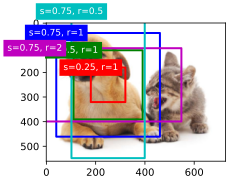

In [8]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'])

## IoU

我们刚刚提到某个锚框“较好地”覆盖了图像中的狗。
如果已知目标的真实边界框，那么这里的“好”该如何如何量化呢？
直观地说，可以衡量锚框和真实边界框之间的相似性。
*杰卡德系数*（Jaccard）可以衡量两组之间的相似性。
给定集合$\mathcal{A}$和$\mathcal{B}$，他们的杰卡德系数是他们交集的大小除以他们并集的大小：

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$

事实上，我们可以将任何边界框的像素区域视为一组像素。通
过这种方式，我们可以通过其像素集的杰卡德系数来测量两个边界框的相似性。
对于两个边界框，它们的杰卡德系数通常称为*交并比*（intersection over union，IoU），即两个边界框相交面积与相并面积之比。
交并比的取值范围在0和1之间：0表示两个边界框无重合像素，1表示两个边界框完全重合。

In [10]:
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]))
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

### Assignment

给定图像，假设锚框是$A_1, A_2, \ldots, A_{n_a}$，真实边界框是$B_1, B_2, \ldots, B_{n_b}$，其中$n_a \geq n_b$。
让我们定义一个矩阵$\mathbf{X} \in \mathbb{R}^{n_a \times n_b}$，其中第$i$行、第$j$列的元素$x_{ij}$是锚框$A_i$和真实边界框$B_j$的IoU。
该算法包含以下步骤。

1. 在矩阵$\mathbf{X}$中找到最大的元素，并将它的行索引和列索引分别表示为$i_1$和$j_1$。然后将真实边界框$B_{j_1}$分配给锚框$A_{i_1}$。这很直观，因为$A_{i_1}$和$B_{j_1}$是所有锚框和真实边界框配对中最相近的。在第一个分配完成后，丢弃矩阵中${i_1}^\mathrm{th}$行和${j_1}^\mathrm{th}$列中的所有元素。
1. 在矩阵$\mathbf{X}$中找到剩余元素中最大的元素，并将它的行索引和列索引分别表示为$i_2$和$j_2$。我们将真实边界框$B_{j_2}$分配给锚框$A_{i_2}$，并丢弃矩阵中${i_2}^\mathrm{th}$行和${j_2}^\mathrm{th}$列中的所有元素。
1. 此时，矩阵$\mathbf{X}$中两行和两列中的元素已被丢弃。我们继续，直到丢弃掉矩阵$\mathbf{X}$中$n_b$列中的所有元素。此时已经为这$n_b$个锚框各自分配了一个真实边界框。
1. 只遍历剩下的$n_a - n_b$个锚框。例如，给定任何锚框$A_i$，在矩阵$\mathbf{X}$的第$i^\mathrm{th}$行中找到与$A_i$的IoU最大的真实边界框$B_j$，只有当此IoU大于预定义的阈值时，才将$B_j$分配给$A_i$。

![将真实边界框分配给锚框。](./img/anchor-label.svg)

此算法在下面的`assign_anchor_to_bbox`函数中实现。

In [11]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device)
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes, ), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

### Sign

现在我们可以为每个锚框标记类别和偏移量了。
假设一个锚框$A$被分配了一个真实边界框$B$。
一方面，锚框$A$的类别将被标记为与$B$相同。
另一方面，锚框$A$的偏移量将根据$B$和$A$中心坐标的相对位置以及这两个框的相对大小进行标记。
鉴于数据集内不同的框的位置和大小不同，我们可以对那些相对位置和大小应用变换，使其获得分布更均匀且易于拟合的偏移量。
这里介绍一种常见的变换。
给定框$A$和$B$，中心坐标分别为$(x_a, y_a)$和$(x_b, y_b)$，宽度分别为$w_a$和$w_b$，高度分别为$h_a$和$h_b$，可以将$A$的偏移量标记为：

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$

其中常量的默认值为 $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1$ ， $\sigma_w=\sigma_h=0.2$。
这种转换在下面的 `offset_boxes` 函数中实现。

In [12]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

如果一个锚框没有被分配真实边界框，我们只需将锚框的类别标记为*背景*（background）。
背景类别的锚框通常被称为*负类*锚框，其余的被称为*正类*锚框。
我们使用真实边界框（`labels`参数）实现以下`multibox_target`函数，来**标记锚框的类别和偏移量**（`anchors`参数）。
此函数将背景类别的索引设置为零，然后将新类别的整数索引递增一。


In [13]:
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)

        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)

    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

下面通过一个具体的例子来说明锚框标签。
我们已经为加载图像中的狗和猫定义了真实边界框，其中第一个元素是类别（0代表狗，1代表猫），其余四个元素是左上角和右下角的$(x, y)$轴坐标（范围介于0和1之间）。
我们还构建了五个锚框，用左上角和右下角的坐标进行标记：$A_0, \ldots, A_4$（索引从0开始）。
然后我们**在图像中绘制这些真实边界框和锚框**。

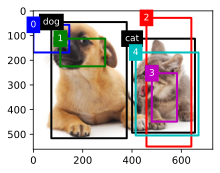

In [14]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

使用上面定义的`multibox_target`函数，我们可以**根据狗和猫的真实边界框，标注这些锚框的分类和偏移量**。
在这个例子中，背景、狗和猫的类索引分别为0、1和2。
下面我们为锚框和真实边界框样本添加一个维度。


In [15]:
labels = multibox_target(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))

返回的结果中有三个元素，都是张量格式。第三个元素包含标记的输入锚框的类别。

让我们根据图像中的锚框和真实边界框的位置来分析下面返回的类别标签。
首先，在所有的锚框和真实边界框配对中，锚框$A_4$与猫的真实边界框的IoU是最大的。
因此，$A_4$的类别被标记为猫。
去除包含$A_4$或猫的真实边界框的配对，在剩下的配对中，锚框$A_1$和狗的真实边界框有最大的IoU。
因此，$A_1$的类别被标记为狗。
接下来，我们需要遍历剩下的三个未标记的锚框：$A_0$、$A_2$和$A_3$。
对于$A_0$，与其拥有最大IoU的真实边界框的类别是狗，但IoU低于预定义的阈值（0.5），因此该类别被标记为背景；
对于$A_2$，与其拥有最大IoU的真实边界框的类别是猫，IoU超过阈值，所以类别被标记为猫；
对于$A_3$，与其拥有最大IoU的真实边界框的类别是猫，但值低于阈值，因此该类别被标记为背景。

In [16]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

返回的第二个元素是掩码（mask）变量，形状为（批量大小，锚框数的四倍）。
掩码变量中的元素与每个锚框的4个偏移量一一对应。
由于我们不关心对背景的检测，负类的偏移量不应影响目标函数。
通过元素乘法，掩码变量中的零将在计算目标函数之前过滤掉负类偏移量。

In [17]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

返回的第一个元素包含了为每个锚框标记的四个偏移值。
请注意，负类锚框的偏移量被标记为零。


In [18]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

### Using Non-Max to Supress the bbox

在预测时，我们先为图像生成多个锚框，再为这些锚框一一预测类别和偏移量。
一个预测好的边界框则根据其中某个带有预测偏移量的锚框而生成。
下面我们实现了`offset_inverse`函数，该函数将锚框和偏移量预测作为输入，并**应用逆偏移变换来返回预测的边界框坐标**。

In [19]:
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

当有许多锚框时，可能会输出许多相似的具有明显重叠的预测边界框，都围绕着同一目标。
为了简化输出，我们可以使用*非极大值抑制*（non-maximum suppression，NMS）合并属于同一目标的类似的预测边界框。

以下是非极大值抑制的工作原理。
对于一个预测边界框$B$，目标检测模型会计算每个类别的预测概率。
假设最大的预测概率为$p$，则该概率所对应的类别$B$即为预测的类别。
具体来说，我们将$p$称为预测边界框$B$的*置信度*（confidence）。
在同一张图像中，所有预测的非背景边界框都按置信度降序排序，以生成列表$L$。然后我们通过以下步骤操作排序列表$L$。

1. 从$L$中选取置信度最高的预测边界框$B_1$作为基准，然后将所有与$B_1$的IoU超过预定阈值$\epsilon$的非基准预测边界框从$L$中移除。这时，$L$保留了置信度最高的预测边界框，去除了与其太过相似的其他预测边界框。简而言之，那些具有*非极大值*置信度的边界框被*抑制*了。
1. 从$L$中选取置信度第二高的预测边界框$B_2$作为又一个基准，然后将所有与$B_2$的IoU大于$\epsilon$的非基准预测边界框从$L$中移除。
1. 重复上述过程，直到$L$中的所有预测边界框都曾被用作基准。此时，$L$中任意一对预测边界框的IoU都小于阈值$\epsilon$；因此，没有一对边界框过于相似。
1. 输出列表$L$中的所有预测边界框。

**以下`nms`函数按降序对置信度进行排序并返回其索引**。

In [20]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4), boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

我们定义以下`multibox_detection`函数来**将非极大值抑制应用于预测边界框**。
这里的实现有点复杂，请不要担心。我们将在实现之后，马上用一个具体的例子来展示它是如何工作的。

In [21]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

现在让我们**将上述算法应用到一个带有四个锚框的具体示例中**。
为简单起见，我们假设预测的偏移量都是零，这意味着预测的边界框即是锚框。
对于背景、狗和猫其中的每个类，我们还定义了它的预测概率。

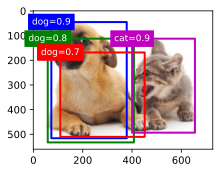

In [22]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

现在我们可以调用`multibox_detection`函数来执行非极大值抑制，其中阈值设置为0.5。
请注意，我们在示例的张量输入中添加了维度。

我们可以看到**返回结果的形状是（批量大小，锚框的数量，6）**。
最内层维度中的六个元素提供了同一预测边界框的输出信息。
第一个元素是预测的类索引，从0开始（0代表狗，1代表猫），值-1表示背景或在非极大值抑制中被移除了。
第二个元素是预测的边界框的置信度。
其余四个元素分别是预测边界框左上角和右下角的$(x, y)$轴坐标（范围介于0和1之间）。


In [23]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

删除-1类别（背景）的预测边界框后，我们可以**输出由非极大值抑制保存的最终预测边界框**。


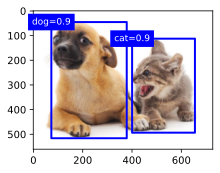

In [24]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

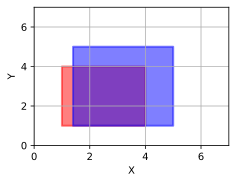

tensor([[0.50]])


In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
warnings.filterwarnings("ignore")

def plot_boxes(boxes1, boxes2):
    fig, ax = plt.subplots()
    # 绘制第一个边界框
    rect1 = patches.Rectangle((boxes1[:,0], boxes1[:,1]), boxes1[:,2]-boxes1[:,0], boxes1[:,3]-boxes1[:,1], linewidth=2, edgecolor='r', facecolor='r',alpha=0.5)
    ax.add_patch(rect1)
    # 绘制第二个边界框
    rect2 = patches.Rectangle((boxes2[:,0], boxes2[:,1]), boxes2[:,2]-boxes2[:,0], boxes2[:,3]-boxes2[:,1], linewidth=2, edgecolor='b', facecolor='b',alpha=0.5)
    ax.add_patch(rect2)

    ax.set_xlim(0, 7)
    ax.set_ylim(0, 7)

    ax.set_xticks([0, 2, 4, 6])
    ax.set_yticks([0, 2, 4, 6])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True)
    plt.show()

boxes1 = torch.tensor([[1,1,4,4]])
boxes2 = torch.tensor([[1.4,1,5,5]])
plot_boxes(boxes1, boxes2)
# 计算IoU
iou = box_iou(boxes1, boxes2)
print(iou)

## Multiscale object detection

减少图像上的锚框数量并不困难。
比如，我们可以在输入图像中均匀采样一小部分像素，并以它们为中心生成锚框。
此外，在不同尺度下，我们可以生成不同数量和不同大小的锚框。
直观地说，比起较大的目标，较小的目标在图像上出现的可能性更多样。
例如，$1 \times 1$、$1 \times 2$和$2 \times 2$的目标可以分别以4、2和1种可能的方式出现在$2 \times 2$图像上。
因此，当使用较小的锚框检测较小的物体时，我们可以采样更多的区域，而对于较大的物体，我们可以采样较少的区域。

In [1]:
import torch
from d2l import torch as d2l

img = d2l.plt.imread('./img/catdog.jpg')
h, w = img.shape[:2]
h, w

(561, 728)

回想一下，在 :numref:`sec_conv_layer`中，我们将卷积图层的二维数组输出称为特征图。
通过定义特征图的形状，我们可以确定任何图像上均匀采样锚框的中心。

`display_anchors`函数定义如下。
我们[**在特征图（`fmap`）上生成锚框（`anchors`），每个单位（像素）作为锚框的中心**]。
由于锚框中的$(x, y)$轴坐标值（`anchors`）已经被除以特征图（`fmap`）的宽度和高度，因此这些值介于0和1之间，表示特征图中锚框的相对位置。

由于锚框（`anchors`）的中心分布于特征图（`fmap`）上的所有单位，因此这些中心必须根据其相对空间位置在任何输入图像上*均匀*分布。
更具体地说，给定特征图的宽度和高度`fmap_w`和`fmap_h`，以下函数将*均匀地*对任何输入图像中`fmap_h`行和`fmap_w`列中的像素进行采样。
以这些均匀采样的像素为中心，将会生成大小为`s`（假设列表`s`的长度为1）且宽高比（`ratios`）不同的锚框。


In [2]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    # 前两个维度上的值不影响输出
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes, anchors[0] * bbox_scale)

首先，让我们考虑**探测小目标**。
为了在显示时更容易分辨，在这里具有不同中心的锚框不会重叠：
锚框的尺度设置为0.15，特征图的高度和宽度设置为4。
我们可以看到，图像上4行和4列的锚框的中心是均匀分布的。

c:\Users\Jason Chen\.conda\envs\d2l\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


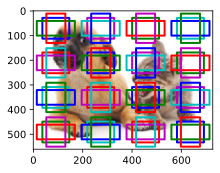

In [3]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

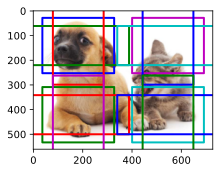

In [9]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

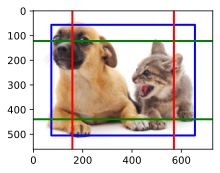

In [10]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

## Object Detection

In [11]:
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [32]:
## Change the pwd!
import hashlib
import zipfile
import tarfile
import requests
DATA_HUB = dict()


def download(name, cache_dir=os.path.join('.', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename.

    Defined in :numref:`sec_kaggle_house`"""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """Download and extract a zip/tar file.

    Defined in :numref:`sec_kaggle_house`"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [33]:
DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

通过`read_data_bananas`函数，我们**读取香蕉检测数据集**。
该数据集包括一个的CSV文件，内含目标类别标签和位于左上角和右下角的真实边界框坐标。


In [38]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train 
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

通过使用`read_data_bananas`函数读取图像和标签，以下`BananasDataset`类别将允许我们**创建一个自定义`Dataset`实例**来加载香蕉检测数据集。


In [35]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))
        
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])
    
    def __len__(self):
        return len(self.features)

最后，我们定义`load_data_bananas`函数，来**为训练集和测试集返回两个数据加载器实例**。对于测试集，无须按随机顺序读取它。

In [36]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True), 
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False), 
                                             batch_size)
    return train_iter, val_iter

让我们**读取一个小批量，并打印其中的图像和标签的形状**。
图像的小批量的形状为（批量大小、通道数、高度、宽度），看起来很眼熟：它与我们之前图像分类任务中的相同。
标签的小批量的形状为（批量大小，$m$，5），其中$m$是数据集的任何图像中边界框可能出现的最大数量。

小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。
通常来说，图像可能拥有不同数量个边界框；因此，在达到$m$之前，边界框少于$m$的图像将被非法边界框填充。
这样，每个边界框的标签将被长度为5的数组表示。
数组中的第一个元素是边界框中对象的类别，其中-1表示用于填充的非法边界框。
数组的其余四个元素是边界框左上角和右下角的（$x$，$y$）坐标值（值域在0～1之间）。
对于香蕉数据集而言，由于每张图像上只有一个边界框，因此$m=1$。

In [39]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

让我们展示10幅带有真实边界框的图像。
我们可以看到在所有这些图像中香蕉的旋转角度、大小和位置都有所不同。
当然，这只是一个简单的人工数据集，实践中真实世界的数据集通常要复杂得多。

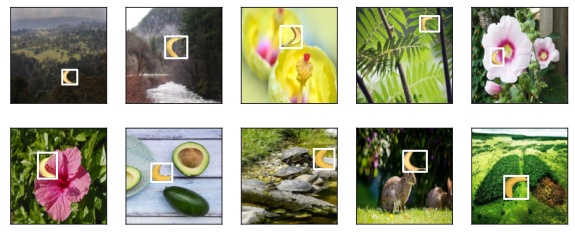

In [40]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## SSD(单发多框检测)

在`bbox`— `object-detection-dataset`中，我们分别介绍了边界框、锚框、多尺度目标检测和用于目标检测的数据集。
现在我们已经准备好使用这样的背景知识来设计一个目标检测模型：单发多框检测（SSD） (`Liu.Anguelov.Erhan.ea.2016`)。
该模型简单、快速且被广泛使用。尽管这只是其中一种目标检测模型，但本节中的一些设计原则和实现细节也适用于其他模型。

![单发多框检测模型主要由一个基础网络块和若干多尺度特征块串联而成。](./img/ssd.svg)

单发多框检测模型主要由基础网络组成，其后是几个多尺度特征块。
基本网络用于从输入图像中提取特征，因此它可以使用深度卷积神经网络。
单发多框检测论文中选用了在分类层之前截断的VGG，现在也常用ResNet替代。
我们可以设计基础网络，使它输出的高和宽较大。
这样一来，基于该特征图生成的锚框数量较多，可以用来检测尺寸较小的目标。
接下来的每个多尺度特征块将上一层提供的特征图的高和宽缩小（如减半），并使特征图中每个单元在输入图像上的感受野变得更广阔。

回想一下在`multiscale-object-detection`中，通过深度神经网络分层表示图像的多尺度目标检测的设计。

由于接近顶部的多尺度特征图较小，但具有较大的感受野，它们适合检测较少但较大的物体。
简而言之，通过多尺度特征块，单发多框检测生成不同大小的锚框，并通过预测边界框的类别和偏移量来检测大小不同的目标，因此这是一个多尺度目标检测模型。

设目标类别的数量为$q$。这样一来，锚框有$q+1$个类别，其中0类是背景。
在某个尺度下，设特征图的高和宽分别为$h$和$w$。
如果以其中每个单元为中心生成$a$个锚框，那么我们需要对$hwa$个锚框进行分类。
如果使用全连接层作为输出，很容易导致模型参数过多。
回忆`nin`一节介绍的使用卷积层的通道来输出类别预测的方法，
单发多框检测采用同样的方法来降低模型复杂度。

具体来说，类别预测层使用一个保持输入高和宽的卷积层。
这样一来，输出和输入在特征图宽和高上的空间坐标一一对应。
考虑输出和输入同一空间坐标（$x$、$y$）：输出特征图上（$x$、$y$）坐标的通道里包含了以输入特征图（$x$、$y$）坐标为中心生成的所有锚框的类别预测。
因此输出通道数为$a(q+1)$，其中索引为$i(q+1) + j$（$0 \leq j \leq q$）的通道代表了索引为$i$的锚框有关类别索引为$j$的预测。

在下面，我们定义了这样一个类别预测层，通过参数`num_anchors`和`num_classes`分别指定了$a$和$q$。
该图层使用填充为1的$3\times3$的卷积层。此卷积层的输入和输出的宽度和高度保持不变。


In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1)

边界框预测层的设计与类别预测层的设计类似。
唯一不同的是，这里需要为每个锚框预测4个偏移量，而不是$q+1$个类别。

In [2]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4,kernel_size=3, padding=1)

正如我们所提到的，单发多框检测使用多尺度特征图来生成锚框并预测其类别和偏移量。
在不同的尺度下，特征图的形状或以同一单元为中心的锚框的数量可能会有所不同。
因此，不同尺度下预测输出的形状可能会有所不同。

在以下示例中，我们为同一个小批量构建两个不同比例（`Y1`和`Y2`）的特征图，其中`Y2`的高度和宽度是`Y1`的一半。
以类别预测为例，假设`Y1`和`Y2`的每个单元分别生成了$5$个和$3$个锚框。
进一步假设目标类别的数量为$10$，对于特征图`Y1`和`Y2`，类别预测输出中的通道数分别为$5\times(10+1)=55$和$3\times(10+1)=33$，其中任一输出的形状是（批量大小，通道数，高度，宽度）。


In [3]:
# 连接多尺度的预测
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

正如我们所看到的，除了批量大小这一维度外，其他三个维度都具有不同的尺寸。
为了将这两个预测输出链接起来以提高计算效率，我们将把这些张量转换为更一致的格式。

通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。
因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的（批量大小，高$\times$宽$\times$通道数）的格式，以方便之后在维度$1$上的连结。

In [4]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3,1),start_dim=1)  # shape=(2, x)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [5]:
concat_preds([Y1, Y2]).shape  # 22000 + 3300 

torch.Size([2, 25300])

为了在多个尺度下检测目标，我们在下面定义了高和宽减半块`down_sample_blk`，该模块将输入特征图的高度和宽度减半。
事实上，该块应用了在`vgg-blocks`中的VGG模块设计。
更具体地说，每个高和宽减半块由两个填充为$1$的$3\times3$的卷积层、以及步幅为$2$的$2\times2$最大汇聚层组成。
我们知道，填充为$1$的$3\times3$卷积层不改变特征图的形状。但是，其后的$2\times2$的最大汇聚层将输入特征图的高度和宽度减少了一半。
对于此高和宽减半块的输入和输出特征图，因为$1\times 2+(3-1)+(3-1)=6$，所以输出中的每个单元在输入上都有一个$6\times6$的感受野。因此，高和宽减半块会扩大每个单元在其输出特征图中的感受野。

In [6]:
# 高宽减半
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [7]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

基本网络块用于从输入图像中抽取特征。
为了计算简洁，我们构造了一个小的基础网络，该网络串联3个高和宽减半块，并逐步将通道数翻倍。
给定输入图像的形状为$256\times256$，此基本网络块输出的特征图形状为$32 \times 32$（$256/2^3=32$）。

In [8]:
# 基本网络块
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

**完整的单发多框检测模型由五个模块组成**。每个块生成的特征图既用于生成锚框，又用于预测这些锚框的类别和偏移量。在这五个模块中，第一个是基本网络块，第二个到第四个是高和宽减半块，最后一个模块使用全局最大池将高度和宽度都降到1。从技术上讲，第二到第五个区块都是多尺度特征块。


In [9]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

现在我们**为每个块定义前向传播**。与图像分类任务不同，此处的输出包括：CNN特征图`Y`；在当前尺度下根据`Y`生成的锚框；预测的这些锚框的类别和偏移量（基于`Y`）。

In [10]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, size=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

一个较接近顶部的多尺度特征块是用于检测较大目标的，因此需要生成更大的锚框。
在上面的前向传播中，在每个多尺度特征块上，我们通过调用的`multibox_prior`函数的`sizes`参数传递两个比例值的列表。
在下面，0.2和1.05之间的区间被均匀分成五个部分，以确定五个模块的在不同尺度下的较小值：0.2、0.37、0.54、0.71和0.88。
之后，他们较大的值由$\sqrt{0.2 \times 0.37} = 0.272$、$\sqrt{0.37 \times 0.54} = 0.447$等给出。

In [11]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 1, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

现在，我们就可以按如下方式**定义完整的模型**`TinySSD`了。

In [ ]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_channels[i], num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_channels[i], num_anchors))
    
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(X, getattr(self, ))
